<br>
# ** 6 Predict the TimeSeries Data**
시계열 데이터 예측

<br><br>
## **2 ARIMA 시계열 분석을 활용한 주가예측**
**자기회귀 누적이동평균** | Auto Regressive Integrated Moving Average
1. [ARIMA 개념설명 사이트](https://m.blog.naver.com/bluefish850/220749045909)
1. [DataScience 정리내용](https://datascienceschool.net/view-notebook/743cdedec523447a907b2b0abda45533/)
1. [ARIMA Python 외국사이트](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)
1. [ARMA 차수모델 검정](http://blog.naver.com/PostView.nhn?blogId=hsj2864&logNo=220856817524&parentCategoryNo=&categoryNo=31&viewDate=&isShowPopularPosts=false&from=postView)

In [1]:
from pandas_datareader import get_data_yahoo
stock = get_data_yahoo('032830.KS', '2017-01-01')
stock.tail(3)
price = stock.Close

<br>
### ** 01-1. ACF & PACF Plots**
pip install --no-cache-dir statsmodels [Blog](https://byeongkijeong.github.io/ARIMA-with-Python/)
1. **ARMA(자기회귀 이동평균)** 모형은 AR모델과 MA모델의 결합이다
1. ACF : 자기상관함수(ACF, AutoCorrelation Function)
1. PACF : 편자기상관함수(PACF, Partial Autocorrelation Function)

### **AR(자기회귀)의 특성** 
1. 이전 가격이 이후의 값에 대해 영향을 미침으로써, 고유한 평균값을 기준으로 움직이는 속성을 의미한다
1. 이 경우, **ACF는 천천히 감소**하고 PACF는 처음 시차를 제외하고 급격히 감소 한다.
1. X(t)={ a * X(t-1)+c } + u * e(t)

### **MA(이동평균)의 특성**
1. 가격정보가 시간의 흐름에 따라 일정한 방향성을 갖고서 증가/ 감소하는 속성을 의미한다
1. ACF는 급격히 감소하고 **PACF는 천천히 감소**
1. X(t) = { a*e (t-1) + c } + u*e(t)
1. X(t)는 **평균이 a*e(t-1)** 이며 **분산이 u** 인 **정규분포**에서 도출되는 임의의 값

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plot_acf(price); plt.show()
# ACF (자기회귀 특성) : 불규칙한 요동을 친다

/home/markbaum/Python/python/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


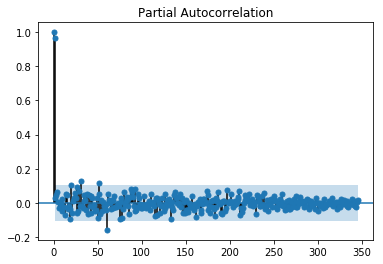

In [3]:
plot_pacf(price); plt.show()
# PACF (이동평균 특성) 급격히 떨어진 뒤 완만한 폭에서 변동을 갖는다
# 처음은 왜 높을까?
# 이동평균을 계산할 충분한 데이터가 없기 때문이다

<br>
### ** 01-2. ACF & PACF Plots 2**
차분 .diff() 데이터를 사용하여 분석하기

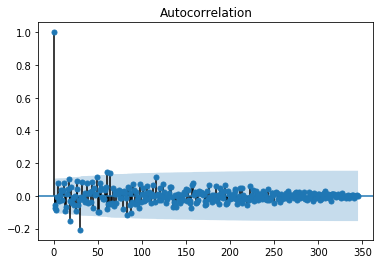

In [4]:
# 1차 차분(Diff)한 뒤 변화를 살펴본다
# ACF (자기회귀 특성) : 상대적으로 안정적인 데이터로 전환
diff_1 = price.diff(periods=1).dropna()#.iloc[1:]
plot_acf(diff_1); plt.show()

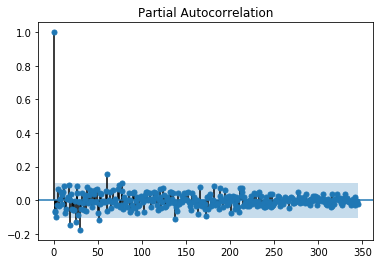

In [5]:
plot_pacf(diff_1)
plt.show()
# 차분 이후의 ACF, PACF를 본 결과 PACF 경향이 더 도드라 진다
# PCAF가 안전된 만큼, MA 성향이 더 도드라 진다

<br>
### **02-1 선형 모델의 해석**
Ordinary Least Squares regression (**OLS**)

### **OLS(최소자승법)** 
[우도의 개념과 추정](http://to302.phps.kr/wordpress/?p=63)
1. Sum of Square를 최소화하는 것이 가장 좋은 회귀직선이라 정한 것 뿐이지, 그게 정말 맞다고 누가 장담할 수 있나? 
1. 그렇게 하기로 한 것 뿐이지. 아니 – 넓게 말하면 최소자승법 역시 하나의 최대우도추정이라고 할 수도 있는 것이다.

In [6]:
from sklearn.datasets import load_iris 
data = load_iris()

import pandas as pd
df = pd.DataFrame(data.data)
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df['class'] = [data.target_names[no]   for no in data.target]
df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


Text(0.5,1.2,'Setosa Sepal Width vs. Sepal Length')

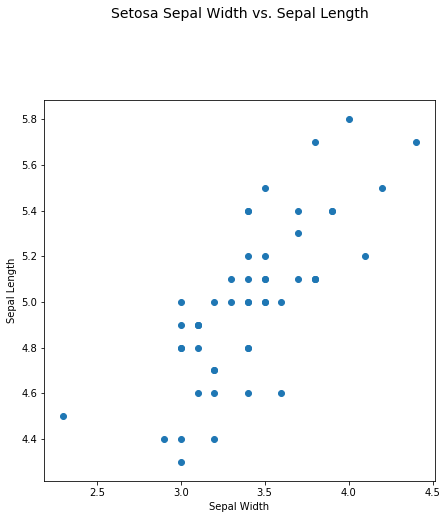

In [7]:
# Setosa 품종의 꽃받침 길이와 너비관계를 선형회귀 모델을 만든다
%matplotlib inline

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df['sepal_width'][:50], df['sepal_length'][:50])
ax.set_ylabel('Sepal Length')
ax.set_xlabel('Sepal Width')
ax.set_title('Setosa Sepal Width vs. Sepal Length', fontsize=14, y=1.2)

In [8]:
import warnings
warnings.filterwarnings("ignore")

# 데이터 분포를 살펴본결과 선형을 볼 수 있다
# statsmodels 을 사용하여 선형회귀 모델로 검증한다
import statsmodels.api as sm

y = df['sepal_length'][:50]
y[:10]

0    5.1
1    4.9
2    4.7
3    4.6
4    5.0
5    5.4
6    4.6
7    5.0
8    4.4
9    4.9
Name: sepal_length, dtype: float64

In [9]:
df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


In [10]:
x = df['sepal_width'][:50]
X = sm.add_constant(x)
X[:10]

,const,sepal_width
0,1.0,3.5
1,1.0,3.0
2,1.0,3.2
3,1.0,3.1
4,1.0,3.6
5,1.0,3.9
6,1.0,3.4
7,1.0,3.4
8,1.0,2.9
9,1.0,3.1


In [11]:
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           sepal_length   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     60.52
Date:                Thu, 07 Jun 2018   Prob (F-statistic):           4.75e-10
Time:                        20:40:21   Log-Likelihood:                 2.0879
No. Observations:                  50   AIC:                           -0.1759
Df Residuals:                      48   BIC:                             3.648
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.6447      0.305      8.660      

### R-squared : R제곱이 큰만큼 모델의 신뢰성이 높다
1. 절편값(const) 은 2.6447 로 P-value값 표준편차값이 일정해 신뢰성이 높다. 대신 정규성은 낮음
1. 기울기(sepal_width) 는 0.6909 로 P-value 값과 신뢰구간이 좋아서 일정해 신뢰성 높다. 여기도 정규성은 낮다

 **둘 다 값이 작을 수록 올바른 모형에 가깝다.** [개념정리된 블로그](https://datascienceschool.net/view-notebook/bfe4438b46674c68a5ba6598147a5527/)
### **AIC (Akaike Information Criterion)**
AIC는 모형과 데이터의 확률 분포 사이의 Kullback-Leibler 수준을 가장 크게하기 위한 시도에서 나왔다
$$ AIC = - 2 \log L + 2K $$
### **BIC (Bayesian Information Criterion)** 
BIC는 데이터가 exponential family라는 가정하에 주어진 데이터에서 모형의 likelihood를 측정하기 위한 값에서 유도되었다
$$ BIC = − 2 \log L + K \log n $$

### **Likelihood 우도값 개념** 
[우도의 개념과 추정](http://to302.phps.kr/wordpress/?p=63)
1. 확률 : 특정한 포인트를 찍어서 계산을 한다
1. 우도 : 특정한 관찰값이 이미 주어져 있고, 확률분포곡선 자체를 움직이면서 그 관찰값이 가장 잘 나오는 위치를 찾는 것이다
1. 특정 확률분포를 사용해 우도를 구하고, 그 분포를 약간 이동시켜 계산하고… 반복하다가 그 우도가 최대로 결정되는 지점에서 멈추는 것이다. 어쩐지 프로그래밍 기초에서 나오는 것과 유사하다

## **이를 근거로 회귀식을 구현한다**

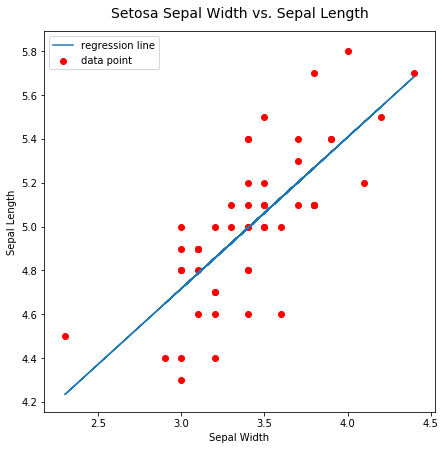

In [12]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(x, results.fittedvalues, label='regression line')
ax.scatter(x, y, label='data point', color='r')
ax.set_ylabel('Sepal Length')
ax.set_xlabel('Sepal Width')
ax.set_title('Setosa Sepal Width vs. Sepal Length', fontsize=14, y=1.02)
ax.legend()

<br>
### ** 02 ARMA 모형 구축**
1. 통상 ARMA(2,2) 정도를 사용하면 양질의 결과를 얻을 수 있다 
1. AR모델과 MA모델에 2차 선형회귀식을 활용

ARMA(p, q)
1. 'p' Lthe model for the number of AR parameters
1. 'q' differences, and MA parameters to use.

In [13]:
import warnings
warnings.filterwarnings("ignore")

import statsmodels.tsa.api as tsa
ARMA = tsa.ARMA(price, order =(2, 2))
ARMA_results= ARMA.fit()

ARMA_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: ARMA
========================================================================
Model:                ARMA              BIC:                  6255.5494 
Dependent Variable:   Close             Log-Likelihood:       -3110.2   
Date:                 2018-06-07 20:40  Scale:                1.0000    
No. Observations:     347               Method:               css-mle   
Df Model:             5                 Sample:               01-02-2017
Df Residuals:         342                                     06-07-2018
Converged:            0.0000            S.D. of innovations:  1881.861  
AIC:                  6232.4534         HQIC:                 6241.649  
------------------------------------------------------------------------
               Coef.     Std.Err.    t    P>|t|     [0.025      0.975]  
------------------------------------------------------------------------
const       115931.5870 3999.8460 28.9840 0.0000 108092.0329 123771.1412
ar.L1.Close      1.3397    0.3543  3.7812 0.0002      0.6453      2.0342
ar.L2.Close     -0.3518    0.3467 -1.0145 0.3110     -1.0314      0.3278
ma.L1.Close     -0.4320    0.3527 -1.2249 0.2214     -1.1233      0.2593
ma.L2.Close     -0.0384    0.0637 -0.6027 0.5471     -0.1633      0.0865
----------------------------------------------------------------------------------
                  Real             Imaginary           Modulus           Frequency
----------------------------------------------------------------------------------
AR.1              1.0192              0.0000            1.0192              0.0000
AR.2              2.7892              0.0000            2.7892              0.0000
MA.1              1.9696              0.0000            1.9696              0.0000
MA.2            -13.2162              0.0000           13.2162              0.5000
========================================================================

"""

## 최대우도추정(MLE:Maximum Likelihood Estimation)
확률 모형의 모수 추정에서 가장 일반적으로 사용되는 방법

## **결과해석**
1. coef : 회귀계수의 기울기값 계산
1. std.Err 표준편차 : 그런데 왜 처음값은 0~1 보다 큰가? (정수만을 사용해서 계산한 결과므로 크다)
1. t : 단일계수 t검정 변화량
1. P>|t| : P-value를 사용한 유의확률의 검정
1. [0.025 ~ 0.975] : 신뢰구간의 데이터값 

## **const**
1. 회귀계수와 상관계수 값이 비이상적으로 출력된다
1. 상수항은 별도로 갖지 않을 가능성이 높다

## **t  Test**
[t 검정 정리사이트](http://www.incodom.kr/%EC%9D%B4%EB%A1%A0_%EB%B0%8F_T%EA%B2%80%EC%A0%95)
1. 단일표본 t검정 : 표본이 하나일 때, 모집단의 평균과 표본집단의 평균 사이에 차이가 있는지를 검증

## **P Value 검정**
1. 귀무가설 : 자신의 주장내용을 'None'으로 되돌리는 가설
1. 대립가설 : 자신의 연구가설
1. 유의수준 : 귀무가설이 타당함을 전제로, 귀무가설에 반하는 데이터가 얻어질 확률
    1. 0.05보다 작으면 : 귀무가설을 기각하여 대립가설이 타당함이 인정된다 (작을수록 좋다)
    1. 0.05보다 크면 : 귀무가설이 타당하다
1. 한계 (Confusion Matrix)
    1. 1종오류 (alpha) : 차이가 없음에도 (대립가설이 효용이 없음에도) 있는걸로 착각 - 덜렁이
    1. 2종오류 (beta) : 차이가 있음에도 발견하지 못하는 실수 - 멍청이

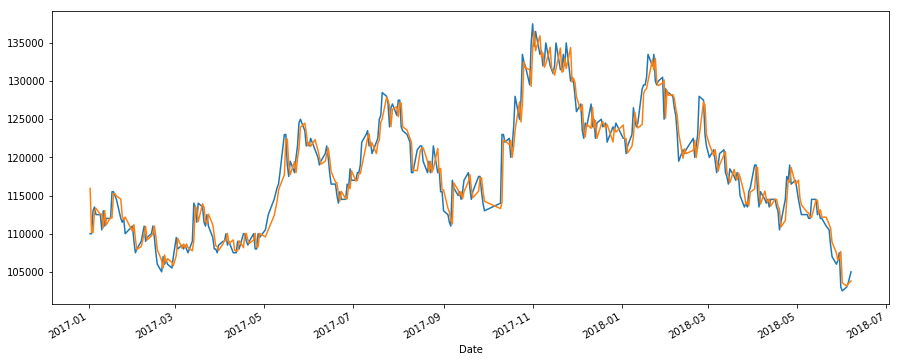

In [14]:
price.plot(figsize=(15,6))
ARMA_results.predict().plot()

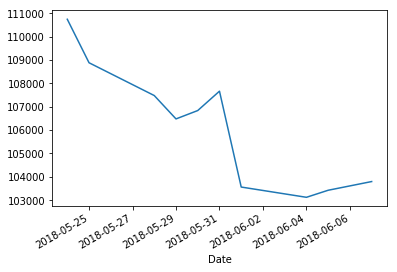

In [15]:
ARMA_results.predict()[-10:].plot()

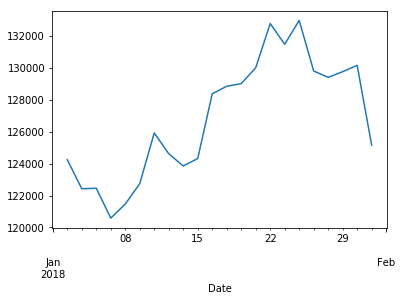

In [16]:
ARMA_results.predict()['2018-01'].plot()

<br>
### ** 03 ARIMA 모형 구축**
1. 1차 차분으로도, 정상상태(Stationary)를 보이므로 ARIMA(0,1,1)을 사용
1. ARMA모델에 비해서 과거의 데이터가 지니고 있던 '추세(Momentum)'까지도 반영

In [17]:
from statsmodels.tsa.arima_model import ARIMA

# order : iterable
#     The (p,d,q) order of the model for 
#  1. the number of AR parameters, (AR에 사용할 파라미터 갯수)
#  2. differences, (차분) 
#  3. and MA parameters to use.    (MA에 사용할 파라미터 갯수)

model     = ARIMA (price, order = (0, 1, 1))
model_fit = model.fit(trend = 'c', full_output = True, disp = 1)
print(model_fit.summary())
# P > |z| P-value 값이 1차차분결과 0.5보다 크므로 정규성이 인정된다

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  346
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3102.716
Method:                       css-mle   S.D. of innovations           1897.778
Date:                Thu, 07 Jun 2018   AIC                           6211.432
Time:                        20:40:22   BIC                           6222.971
Sample:                    01-03-2017   HQIC                          6216.027
                         - 06-07-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -14.4509     93.638     -0.154      0.877    -197.979     169.077
ma.L1.D.Close    -0.0825      0.058     -1.413      0.159      -0.197       0.032
                                    Root

In [18]:
from statsmodels.tsa.arima_model import ARIMA

model     = ARIMA (price, order = (0, 1, 2))
model_fit = model.fit(trend = 'c', full_output = True, disp = 1)
print(model_fit.summary())
# P > |z| P-value 값이 1차차분결과 0.5보다 크므로 정규성이 인정된다

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  346
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3101.814
Method:                       css-mle   S.D. of innovations           1892.800
Date:                Thu, 07 Jun 2018   AIC                           6211.627
Time:                        20:40:22   BIC                           6227.013
Sample:                    01-03-2017   HQIC                          6217.754
                         - 06-07-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -15.9471     85.434     -0.187      0.852    -183.394     151.500
ma.L1.D.Close    -0.0888      0.054     -1.651      0.100      -0.194       0.017
ma.L2.D.Close    -0.0724      0.054     

In [19]:
model = ARIMA(price, order = (0,1,3))
model_fit = model.fit(trend = 'c', full_output = True, disp = 1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  346
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -3100.647
Method:                       css-mle   S.D. of innovations           1886.376
Date:                Thu, 07 Jun 2018   AIC                           6211.293
Time:                        20:40:22   BIC                           6230.525
Sample:                    01-03-2017   HQIC                          6218.951
                         - 06-07-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -16.7942     79.308     -0.212      0.832    -172.236     138.647
ma.L1.D.Close    -0.0820      0.053     -1.543      0.124      -0.186       0.022
ma.L2.D.Close    -0.0510      0.055     

In [20]:
model = ARIMA(price, order = (0,1,4))
model_fit = model.fit(trend = 'c', full_output = True, disp = 1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  346
Model:                 ARIMA(0, 1, 4)   Log Likelihood               -3100.644
Method:                       css-mle   S.D. of innovations           1886.361
Date:                Thu, 07 Jun 2018   AIC                           6213.288
Time:                        20:40:22   BIC                           6236.366
Sample:                    01-03-2017   HQIC                          6222.478
                         - 06-07-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -16.6452     79.551     -0.209      0.834    -172.562     139.272
ma.L1.D.Close    -0.0830      0.055     -1.513      0.131      -0.191       0.025
ma.L2.D.Close    -0.0509      0.055     

### **Z-Score**  <small>http://drhongdatanote.tistory.com/50</small>
1. 개별 데이터값에서 평균을 빼고 그 값을 표준편차로 나눈 값으로
1. 분석대상 데이터를 표준정규분포로 나눈 값이다
1. Z-score 표준 정규분포에서는 -1에서 +1에 전체 데이터의 68%
1. Z-score 표준 정규분포에서는 -2에서 +2 범위에 전체 데이터의 95%
1. Z값이 3이상이 나온다면 우리는 어떻게 이 값을 해석해야 할까요? 좀 튀는 놈이다. 이상한 놈이다. 이렇게 해석
1. 평균값이 서로 다른 데이터를, 평균이 0이고 표준편차가 0~1 로 정규화한다
1. 분자 부분: 어떠한 개별 데이터가 평균으로부터 얼마나 떨어져 있고 (X-\mu )
1. 분모 부분: 그 떨어진 정도가 그 집단의 표준편차의 몇 배 정도 떨어진 것이다" 라는 뜻입니다

### **AIC, BIC 의 비교분석**
information criterion (정보지수) 는 모델의 분석값으로 값이 작을수록 모델이 효과적이다 [개념정리 블로그](https://m.blog.naver.com/PostView.nhn?blogId=lucifer246&logNo=161139569&proxyReferer=https%3A%2F%2Fwww.google.com%2F)
1. Akaike 정보 지수 ( Akaike information criterion : AIC )
2. Bayesian 정보 지수 ( Bayesian information criterion : BIC)

로그 우도함수 값의 차이 는

 검정 ( 우도비 검정 ) 이 불가능하다.

 따라서 정보지수 ( information criterion)을 이용

## **AIC, BIC 의 비교분석**
information criterion (정보지수) 는 모델의 분석값으로 값이 작을수록 모델이 효과적이다
1. Akaike 정보 지수 ( Akaike information criterion : AIC )
2. Bayesian 정보 지수 ( Bayesian information criterion : BIC)

## **AIC, BIC 의 비교분석**
information criterion (정보지수) 는 모델의 분석값으로 값이 작을수록 모델이 효과적이다
1. Akaike 정보 지수 ( Akaike information criterion : AIC )
2. Bayesian 정보 지수 ( Bayesian information criterion : BIC)

### **모델의 해석**
1차분 데이터
2차분 데이터
3차분 데이터

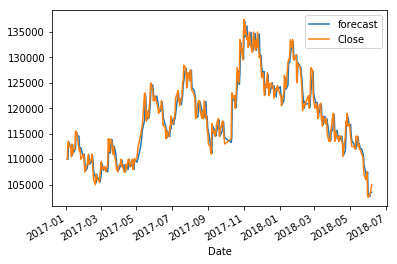

In [21]:
# 위에서 생성한 모델을 사용하여 주가를 예측한다
model_fit.plot_predict(); plt.show()


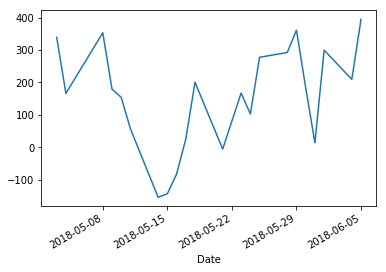

In [22]:
model_fit.predict(start='2018-05-03', end='2018-06-05').plot()#, dynamic=True).plot()

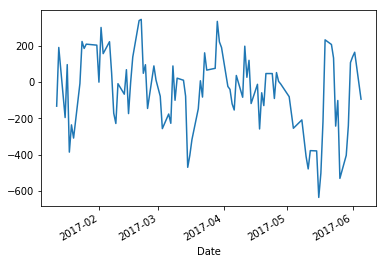

In [23]:
model_fit.predict(start='2017-01-12', end='2017-06-05').plot()

In [24]:
#  마지막 예측값을 수치화 한다
fore = model_fit.forecast(steps = 10)
fore

(array([104826.15259001, 104725.69247352, 104580.36168172, 104569.42512078,
        104552.77994837, 104536.13477596, 104519.48960355, 104502.84443114,
        104486.19925873, 104469.55408632]),
 array([1886.36104917, 2559.37016909, 3036.32596597, 3373.47106738,
        3682.75249646, 3968.00010811, 4234.07413323, 4484.38877368,
        4721.45121559, 4947.16691542]),
 array([[101128.9528718 , 108523.35230822],
        [ 99709.419119  , 109741.96582803],
        [ 98629.27214309, 110531.45122035],
        [ 97957.54332583, 111181.30691573],
        [ 97334.71769133, 111770.84220541],
        [ 96758.99747342, 112313.27207851],
        [ 96220.85679454, 112818.12241256],
        [ 95713.60394206, 113292.08492022],
        [ 95232.32492141, 113740.07359606],
        [ 94773.2851066 , 114165.82306604]]))

주가예측 : [104826.15259001 104725.69247352 104580.36168172 104569.42512078
 104552.77994837 104536.13477596 104519.48960355 104502.84443114
 104486.19925873 104469.55408632] 
stderr : 1886.3610491694753 
upper bound : 101128.95287179529 
lower bound : 108523.352308218


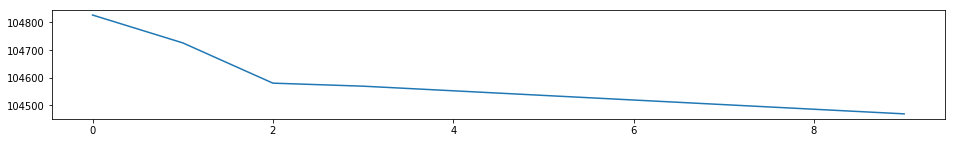

In [25]:
print('주가예측 : {} \nstderr : {} \nupper bound : {} \nlower bound : {}'.format(
    fore[0], 
    fore[1][0], 
    fore[2][0][0], 
    fore[2][0][1]))
pd.Series(fore[0]).plot(figsize=(16,2))